![Photo by Stephen Phillips - Hostreviews.co.uk on UnSplash](https://cf.bstatic.com/xdata/images/hotel/max1024x768/408003083.jpg?k=c49b5c4a2346b3ab002b9d1b22dbfb596cee523b53abef2550d0c92d0faf2d8b&o=&hp=1){fig-align="center" width=50%}


# Import data

In [1]:
from pathlib import Path

import catboost
import pandas as pd
import shap
from data import pre_process, utils
from lets_plot import *
from lets_plot.mapping import as_discrete
from models import train_model
from sklearn import model_selection

LetsPlot.setup_html()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Objective**:  
* Feature Selection
* Feature Engineering




# Prepare dataframe before modelling
## Read in dataframe


In [4]:
df = pd.read_parquet(
    utils.Configuration.INTERIM_DATA_PATH.joinpath(
        "2023-10-01_Processed_dataset_for_NB_use.parquet.gzip"
    )
)

## Train test split

In [5]:
train, test = model_selection.train_test_split(
    df, test_size=0.2, random_state=utils.Configuration.seed
)

print(f"Shape of train: {train.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (2928, 56)
Shape of test: (732, 56)


## Preprocess dataframe for modelling


In [6]:
processed_train = pre_process.prepare_data_for_modelling(train)

Shape of X and y: (2928, 50), (2928,)


# Feature Selection

To perform feature selection, let's split the train set a bit further so that we can use some part of it during catboost training so that we can terminaite the traning when overfitting start to happen.

In [7]:
processed_train = processed_train.drop(columns="folds")
features = processed_train.columns[~processed_train.columns.str.contains("price|folds")]

numerical_features = processed_train.select_dtypes("number").columns.to_list()
categorical_features = processed_train.select_dtypes("object").columns.to_list()

train_FS, validation_FS = model_selection.train_test_split(
    processed_train, test_size=0.2, random_state=utils.Configuration.seed
)

# Get target variables
tr_y = train_FS[utils.Configuration.target_col]
val_y = validation_FS[utils.Configuration.target_col]

# Get feature matrices
tr_X = train_FS.loc[:, features]
val_X = validation_FS.loc[:, features]


print(f"Train dataset shape: {tr_X.shape} {tr_y.shape}")
print(f"Validation dataset shape: {val_X.shape} {val_y.shape}")

Train dataset shape: (2342, 49) (2342,)
Validation dataset shape: (586, 49) (586,)


In [8]:
train_dataset = catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
test_dataset = catboost.Pool(val_X, val_y, cat_features=categorical_features)

In [9]:
model = catboost.CatBoostRegressor(
    iterations=10000,
    random_seed=utils.Configuration.seed,
    loss_function="RMSE",
)

model.fit(
    train_dataset,
    eval_set=[test_dataset],
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=2000,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.014286
0:	learn: 0.3237533	test: 0.3178555	best: 0.3178555 (0)	total: 157ms	remaining: 26m 7s
2000:	learn: 0.0664290	test: 0.1158581	best: 0.1158581 (2000)	total: 43s	remaining: 2m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1146255752
bestIteration = 2493

Shrink model to first 2494 iterations.


In [10]:
# | fig-cap: "Assessing Feature Importance"
# | label: fig-fig1

(
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1, ascending=False)
    .rename(columns={0: "name", 1: "importance"})
    .reset_index(drop=True)
    .pipe(
        lambda df: ggplot(df, aes("name", "importance"))
        + geom_bar(stat="identity")
        + labs(
            title="Assessing Feature Importance",
            subtitle=""" your subttle here
            """,
            x="",
            y="Feature Importance",
            caption="https://www.immoweb.be/",
        )
        + theme(
            plot_subtitle=element_text(
                size=12, face="italic"
            ),  # Customize subtitle appearance
            plot_title=element_text(size=15, face="bold"),  # Customize title appearance
        )
        + ggsize(800, 600)
    )
)

# Shap

In [11]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(
    catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
)

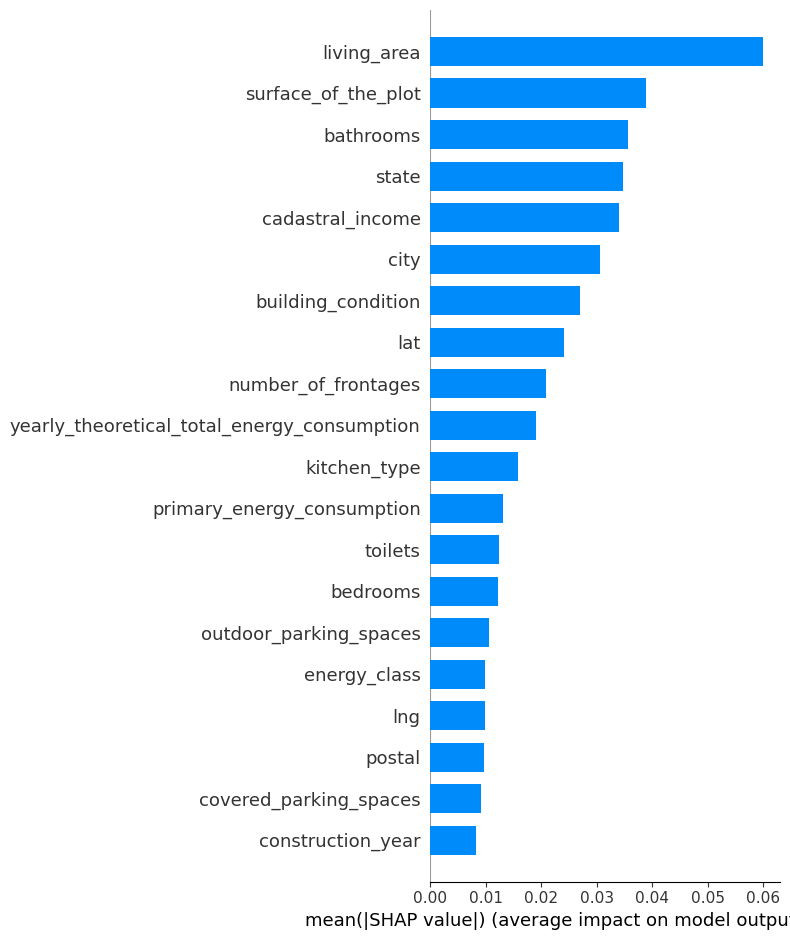

In [19]:
shap.summary_plot(shap_values, tr_X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


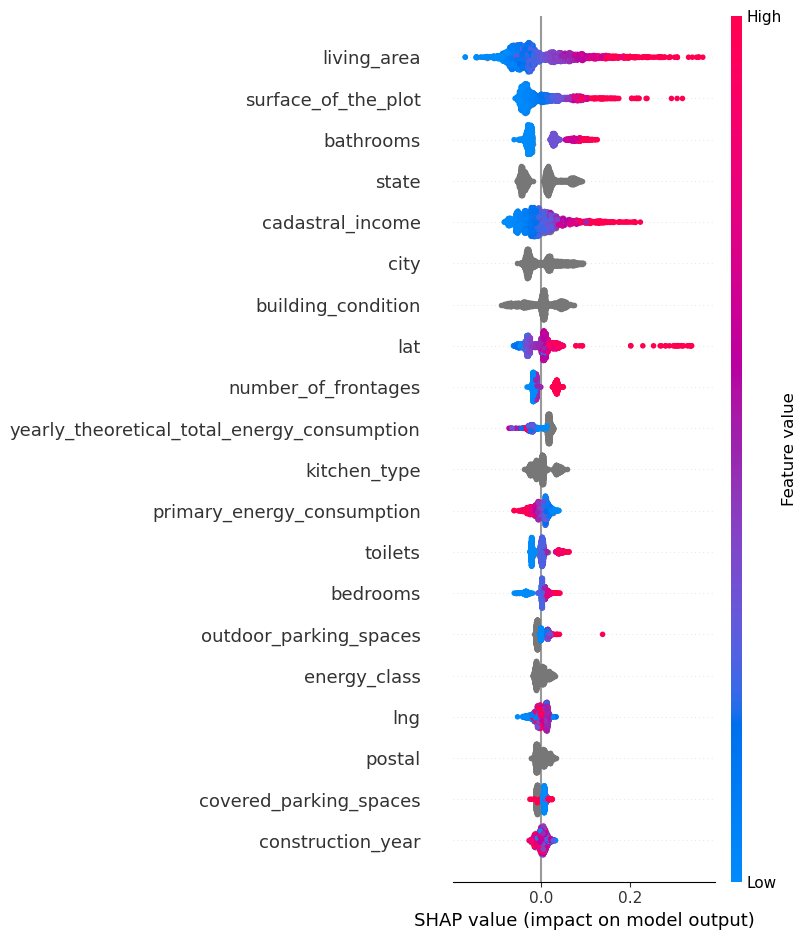

In [20]:
shap.summary_plot(shap_values, tr_X)

# Cross-validation

In [96]:
(
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1, ascending=False)
    .rename(columns={0: "name", 1: "importance"})
    .reset_index(drop=True)
    .pipe(lambda df: ggplot(df, aes("name", "importance")) + geom_bar(stat="identity"))
)

# USe SHAP to explain feature importance

In [ ]:
train_model.run_catboost_CV(processed_train)